## **Import Libraries**

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten , BatchNormalization



from tensorflow.keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns # for confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import json
import os
import numpy as np
import h5py

## **Load Dataset**

In [6]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [8]:
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


## **Visualization**

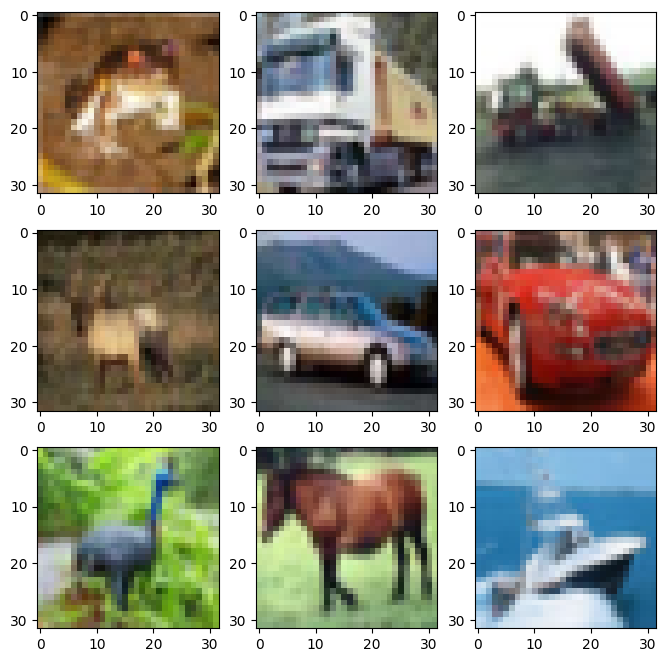

In [9]:
# create a grid of 3x3 images
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = x_train[i]
    plt.imshow(img)
    
# show the plot
plt.show()

## **Preprocess and Splitting**

In [11]:
def normalize(x):
    x = x.astype('float32')
    x = x/255.0
    return x

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
)

### Split Data

In [12]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0) # seed for fixing the x_test and y_test

In [13]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

y_train = tf.keras.utils.to_categorical(y_train , 10) # one hot encoding
y_test = tf.keras.utils.to_categorical(y_test , 10)
y_val  = tf.keras.utils.to_categorical(y_val , 10)

datagen.fit(x_train)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(5000, 10)
(5000, 10)


## **Model**

In [17]:
teacher = load_model("../NoteBook/Teacher/Teacher-3/model.keras")

In [18]:
division_factor = 4
weight_decay = 1e-4
student = Sequential([
    Conv2D(64//division_factor, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(64//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(128//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(256//division_factor, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10)
])

student.summary()



/home/hashem/ML-KnowledgeDistillation/Venv/lib64/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 338,970 (1.29 MB)

 Trainable params: 338,010 (1.29 MB)

 Non-trainable params: 960 (3.75 KB)

### Training

#### Distiller Class

In [19]:
class Distiller(tf.keras.Model):
    def __init__(self,student,teacher,temperature=10,alpha=0.7,**args):
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.distillation_loss_fn = tf.keras.losses.KLDivergence()
        super().__init__(**args)

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self.student(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            student_loss = self.compute_loss(y=y, y_pred=y_pred)

            y_pred_teacher = self.teacher(x,training=False) 
            distillation_loss = self.distillation_loss_fn(
            tf.keras.ops.softmax(y_pred_teacher / self.temperature, axis=1),
            tf.keras.ops.softmax(y_pred / self.temperature, axis=1),
            ) * (self.temperature**2)

            loss = self.alpha*student_loss  + (1- self.alpha)*distillation_loss

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
        
    def test_step(self, data):
        x, y = data
        y_pred = self.student(x, training=False)
        student_loss = self.compute_loss(y=y, y_pred=y_pred)

        y_pred_teacher = self.teacher(x,training=False) 
        distillation_loss = self.distillation_loss_fn(
            tf.keras.ops.softmax(y_pred_teacher / self.temperature, axis=1),
            tf.keras.ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha*student_loss  + (1- self.alpha)*distillation_loss

        for metric in self.metrics:
            if metric.name == "val_loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    def call(self,x):
        return self.student(x)

In [20]:
opt =    tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
distiller = Distiller(teacher, student,alpha=0.75)

distiller.compile(
    opt,
    metrics=['accuracy'],
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    )


In [21]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', 
                                patience=10,
                                cooldown=1,
                                verbose=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=15)]

In [22]:
epoch  = 50
history = distiller.fit(datagen.flow(x_train , y_train , batch_size = 64), epochs = epoch, steps_per_epoch=len(x_train)//64, validation_data = (x_val , y_val) , verbose = 1)

Epoch 1/50


/home/hashem/ML-KnowledgeDistillation/Venv/lib64/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 193s 242ms/step - accuracy: 0.8451 - loss: 1.0136 - val_accuracy: 0.8128 - val_loss: 4.6090
Epoch 2/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:04 237ms/step - accuracy: 0.7500 - loss: 0.8337

2024-06-05 13:04:35.730640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib64/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7500 - loss: 0.4174 - val_accuracy: 0.8122 - val_loss: 4.4622
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 189s 241ms/step - accuracy: 0.8435 - loss: 0.7197 - val_accuracy: 0.8358 - val_loss: 4.5277
Epoch 4/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:02 234ms/step - accuracy: 0.8281 - loss: 0.7558

2024-06-05 13:07:47.830385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8281 - loss: 0.3784 - val_accuracy: 0.8368 - val_loss: 4.8865
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 189s 241ms/step - accuracy: 0.8429 - loss: 0.6874 - val_accuracy: 0.8286 - val_loss: 11.2283
Epoch 6/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:02 234ms/step - accuracy: 0.8906 - loss: 0.5691

2024-06-05 13:11:00.039154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8906 - loss: 0.2849 - val_accuracy: 0.8268 - val_loss: 10.9082
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 241ms/step - accuracy: 0.8431 - loss: 0.6733 - val_accuracy: 0.8476 - val_loss: 5.9334
Epoch 8/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:02 234ms/step - accuracy: 0.7812 - loss: 0.7796

2024-06-05 13:14:11.654250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7812 - loss: 0.3903 - val_accuracy: 0.8480 - val_loss: 5.5456
Epoch 9/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8478 - loss: 0.6636 - val_accuracy: 0.8294 - val_loss: 5.9845
Epoch 10/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:02 234ms/step - accuracy: 0.8438 - loss: 0.6030

2024-06-05 13:17:23.004384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8438 - loss: 0.3019 - val_accuracy: 0.8248 - val_loss: 5.7644
Epoch 11/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8545 - loss: 0.6451 - val_accuracy: 0.8514 - val_loss: 9.1814
Epoch 12/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:05 238ms/step - accuracy: 0.8750 - loss: 0.6552

2024-06-05 13:20:34.259757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8750 - loss: 0.3280 - val_accuracy: 0.8510 - val_loss: 9.2979
Epoch 13/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8536 - loss: 0.6404 - val_accuracy: 0.8166 - val_loss: 5.5671
Epoch 14/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:06 239ms/step - accuracy: 0.8281 - loss: 0.6382

2024-06-05 13:23:45.601244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8281 - loss: 0.3195 - val_accuracy: 0.8158 - val_loss: 5.6013
Epoch 15/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8541 - loss: 0.6380 - val_accuracy: 0.8604 - val_loss: 19.5898
Epoch 16/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:01 232ms/step - accuracy: 0.8438 - loss: 0.6380

2024-06-05 13:26:57.062635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8438 - loss: 0.3194 - val_accuracy: 0.8592 - val_loss: 21.3979
Epoch 17/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8549 - loss: 0.6319 - val_accuracy: 0.8356 - val_loss: 4.9481
Epoch 18/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:04 236ms/step - accuracy: 0.8125 - loss: 0.7339

2024-06-05 13:30:08.359470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8125 - loss: 0.3674 - val_accuracy: 0.8386 - val_loss: 5.2457
Epoch 19/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8585 - loss: 0.6255 - val_accuracy: 0.8576 - val_loss: 6.6667
Epoch 20/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:02 234ms/step - accuracy: 0.8125 - loss: 0.6293

2024-06-05 13:33:19.775058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8125 - loss: 0.3151 - val_accuracy: 0.8596 - val_loss: 6.9209
Epoch 21/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 241ms/step - accuracy: 0.8567 - loss: 0.6236 - val_accuracy: 0.8368 - val_loss: 5.7385
Epoch 22/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:03 235ms/step - accuracy: 0.8281 - loss: 0.6546

2024-06-05 13:36:31.375025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8281 - loss: 0.3277 - val_accuracy: 0.8410 - val_loss: 6.1119
Epoch 23/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 196s 251ms/step - accuracy: 0.8599 - loss: 0.6163 - val_accuracy: 0.8566 - val_loss: 10.5347
Epoch 24/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:59 230ms/step - accuracy: 0.9062 - loss: 0.5441

2024-06-05 13:39:51.158023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9062 - loss: 0.2724 - val_accuracy: 0.8540 - val_loss: 10.8650
Epoch 25/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8601 - loss: 0.6140 - val_accuracy: 0.8336 - val_loss: 4.1683
Epoch 26/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 2:59 230ms/step - accuracy: 0.8906 - loss: 0.5690

2024-06-05 13:43:02.391317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8906 - loss: 0.2849 - val_accuracy: 0.8352 - val_loss: 4.1020
Epoch 27/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8634 - loss: 0.6073 - val_accuracy: 0.8590 - val_loss: 7.0691
Epoch 28/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:05 238ms/step - accuracy: 0.7969 - loss: 0.7125

2024-06-05 13:46:13.533408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7969 - loss: 0.3567 - val_accuracy: 0.8576 - val_loss: 6.8853
Epoch 29/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8591 - loss: 0.6144 - val_accuracy: 0.8080 - val_loss: 6.0454
Epoch 30/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:02 234ms/step - accuracy: 0.8594 - loss: 0.5700

2024-06-05 13:49:24.642198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8594 - loss: 0.2854 - val_accuracy: 0.8032 - val_loss: 6.0195
Epoch 31/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 187s 240ms/step - accuracy: 0.8651 - loss: 0.6037 - val_accuracy: 0.8356 - val_loss: 12.0399
Epoch 32/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:01 233ms/step - accuracy: 0.9219 - loss: 0.5331

2024-06-05 13:52:35.611174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9219 - loss: 0.2669 - val_accuracy: 0.8326 - val_loss: 11.9816
Epoch 33/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.8685 - loss: 0.5985 - val_accuracy: 0.8342 - val_loss: 5.9241
Epoch 34/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:01 233ms/step - accuracy: 0.9219 - loss: 0.5527

2024-06-05 13:55:46.895330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9219 - loss: 0.2767 - val_accuracy: 0.8344 - val_loss: 5.9198
Epoch 35/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 198s 254ms/step - accuracy: 0.8662 - loss: 0.5955 - val_accuracy: 0.8454 - val_loss: 13.3531
Epoch 36/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 4:06 316ms/step - accuracy: 0.8750 - loss: 0.5343

2024-06-05 13:59:09.007819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8750 - loss: 0.2675 - val_accuracy: 0.8456 - val_loss: 14.3497
Epoch 37/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 298s 382ms/step - accuracy: 0.8653 - loss: 0.5987 - val_accuracy: 0.8430 - val_loss: 5.8892
Epoch 38/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:29 499ms/step - accuracy: 0.9375 - loss: 0.6143

2024-06-05 14:04:13.396428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9375 - loss: 0.3076 - val_accuracy: 0.8440 - val_loss: 5.8994
Epoch 39/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 388s 496ms/step - accuracy: 0.8635 - loss: 0.6035 - val_accuracy: 0.8572 - val_loss: 11.1840
Epoch 40/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:37 510ms/step - accuracy: 0.9062 - loss: 0.5804

2024-06-05 14:10:51.811483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9062 - loss: 0.2906 - val_accuracy: 0.8560 - val_loss: 11.2788
Epoch 41/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 388s 496ms/step - accuracy: 0.8694 - loss: 0.5904 - val_accuracy: 0.8534 - val_loss: 9.4173
Epoch 42/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:24 493ms/step - accuracy: 0.8438 - loss: 0.6701

2024-06-05 14:17:28.632187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8438 - loss: 0.3355 - val_accuracy: 0.8508 - val_loss: 8.9910
Epoch 43/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 435s 501ms/step - accuracy: 0.8690 - loss: 0.5912 - val_accuracy: 0.8656 - val_loss: 16.5784
Epoch 44/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:39 512ms/step - accuracy: 0.9219 - loss: 0.5490

2024-06-05 14:24:54.424608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9219 - loss: 0.2749 - val_accuracy: 0.8666 - val_loss: 17.4814
Epoch 45/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 372s 476ms/step - accuracy: 0.8696 - loss: 0.5899 - val_accuracy: 0.8626 - val_loss: 8.6112
Epoch 46/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:49 525ms/step - accuracy: 0.7812 - loss: 0.7835

2024-06-05 14:31:17.227628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7812 - loss: 0.3922 - val_accuracy: 0.8610 - val_loss: 7.9400
Epoch 47/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 445s 494ms/step - accuracy: 0.8758 - loss: 0.5807 - val_accuracy: 0.8676 - val_loss: 8.3329
Epoch 48/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 5:51 450ms/step - accuracy: 0.8438 - loss: 0.5857

2024-06-05 14:38:53.121630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8438 - loss: 0.2932 - val_accuracy: 0.8676 - val_loss: 7.9461
Epoch 49/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 442s 505ms/step - accuracy: 0.8751 - loss: 0.5818 - val_accuracy: 0.8660 - val_loss: 5.5380
Epoch 50/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 6:23 492ms/step - accuracy: 0.8125 - loss: 0.7345

2024-06-05 14:46:23.107185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8125 - loss: 0.3677 - val_accuracy: 0.8650 - val_loss: 5.3459


## **Results and Save**

### **Results**

In [24]:
def plot_results(model):
    epoch = max(
        [
            len(history.history[key]) for key in ["accuracy","val_accuracy","loss","val_loss"]
        ]
        )
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Classification Accuracy")
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Model loss")
    plt.show()

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Args:
    y_true (list or array): True labels.
    y_pred (list or array): Predicted labels.
    classes (list): List of class names for labeling the axes in the plot.
    cmap (matplotlib.colors.Colormap, optional): Colormap to be used for the plot. Defaults to plt.cm.Blues.
    
    Returns:
    None: Displays the confusion matrix.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate model performance metrics including accuracy, precision, recall, and F1 score.
    
    Args:
    y_true (list or array): Actual true labels.
    y_pred (list or array): Predicted labels from the model.
    
    Returns:
    dict: A dictionary containing all the scores.
    """
    scores = {}
    scores['accuracy'] = accuracy_score(y_true, y_pred)
    scores['precision'] = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for unweighted mean
    scores['recall'] = recall_score(y_true, y_pred, average='macro')
    scores['f1_score'] = f1_score(y_true, y_pred, average='macro')
    
    return scores

In [29]:
acc = distiller.student.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)



157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8629 - loss: 0.6624
test set loss :  0.6637778282165527
test set accuracy : 86.04000210762024


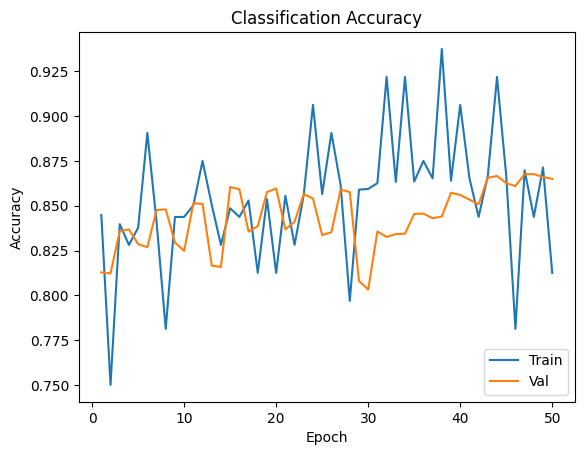

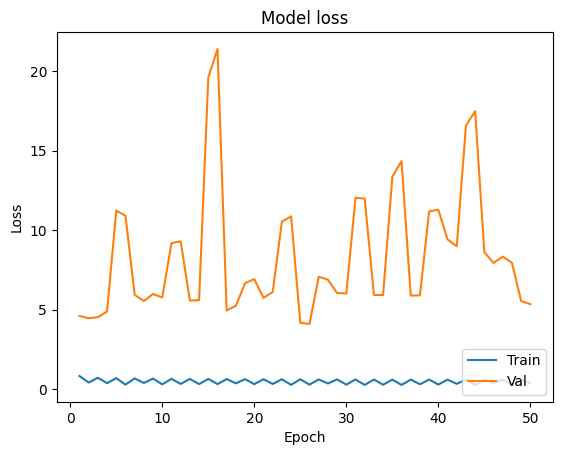

In [30]:
plot_results(distiller)

### Confusion Matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step


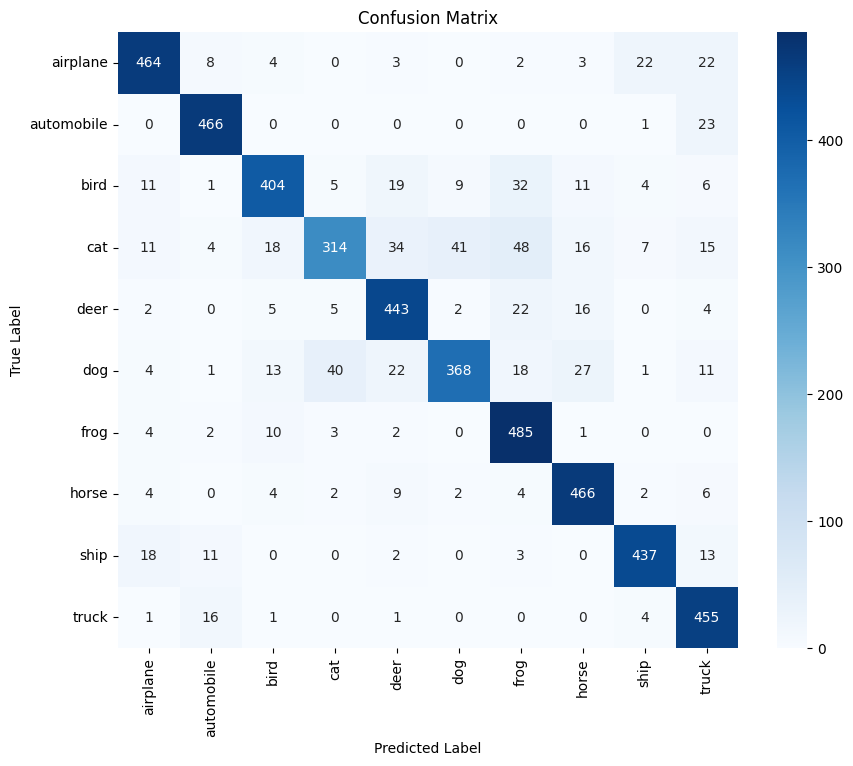

In [32]:
# Make predictions
y_pred = distiller.student.predict(x_test)
# Convert predictions from probabilities to labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)
# Assuming y_test is also in a one-hot encoded format, convert it to labels
y_true_labels = np.argmax(y_test, axis=1)


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
conf_matrix = plot_confusion_matrix(y_true_labels, y_pred_labels,class_names)


### Other Scores

In [33]:
# Evaluate other performance metrics
performance_scores = evaluate_model_performance(y_true_labels, y_pred_labels)
print("Performance Scores:")
for score_name, score_value in performance_scores.items():
    print(f"{score_name.capitalize()}: {score_value}")

Performance Scores:
Accuracy: 0.8604
Precision: 0.8627656707264799
Recall: 0.8614438459766705
F1_score: 0.8578737230227883


### Save

In [34]:
from random import randint
def saveModel(model, history: dict, dir_prefix: str = r"../NoteBook/DistilledStudent", dir_output:str=r"DistilledStudent-1"):
    """
    Creates a directory and saves the model in .h5 format, training history as a JSON file,
    and training and test datasets as .npy files.

    Args:
    model (tf.keras.Model): The trained Keras model to save.
    history (dict): Dictionary containing the training history.
    x_test, y_test, x_train, y_train (numpy.ndarray): Datasets to save.
    output_dir (str, optional): The directory to save all files. Defaults to "TeacherModel".

    Returns:
    bool: True if all files are saved successfully, False if an error occurs.
    """
    try:        
    # Create the directory if it does not exist
        dir_path = os.path.join(dir_prefix, dir_output)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
        history_path = os.path.join(dir_path, "history.json")
        with open(history_path, 'w') as f:
            f.write(json.dumps(history,indent=4))
            f.close()

        model_path = os.path.join(dir_path, "model.keras")
        model.save(model_path)
        

        return True
    except Exception as e:
        print(type(e))
        print(f"An error occurred: {e}")
        
        return False


In [35]:
index = 4
print(saveModel(distiller,history.history,dir_output=f"DistilledStudent-{index}"))

True


In [37]:
! ls ..

BaseNoteBooks  NoteBook  README.md  requirements.txt  Venv
